# Full Sample Regression

Packages

In [1]:
import sys
import numpy as np
import pandas as pd
import statsmodels.api as sm
from   scipy.stats import ttest_1samp

import matplotlib.pyplot as plt
from   matplotlib.ticker import FuncFormatter

Get raw data

In [2]:
sys.path.append(r"C:\Users\Diego\Desktop\app_prod\research\QualityShocks\root\src")
from FullSampleRegression import FullSampleRegression

def get_data() -> pd.DataFrame: 

    keep_tickers = [
        "europe", "global", "global_ex_usa", "pacific", "usa", "quality", 
        "PLEVERUS", "PPROFTUS", "PEARNVUS"]

    renamer = {
        "Pearnvus" : "Bloomberg Profitabiliy",
        "Usa"      : "USA",
        "Pleverus" : "Bloomberg Leverage",
        "Pproftus" : "Bloomberg Profit",
        "quality"  : "JPMorgan Quality"}

    df = (FullSampleRegression().get_full_sample_ols().query(
        "variable == @keep_tickers").
        assign(
            variable = lambda x: x.variable.str.replace("ex_usa", "exUSA").str.replace("_", " ").str.capitalize(),
            group = lambda x: np.where(x.source == "AQR", "AQR", "non_aqr")).
        replace(renamer))
    
    return df

df = get_data()

## Raw QMJ Daily Returns

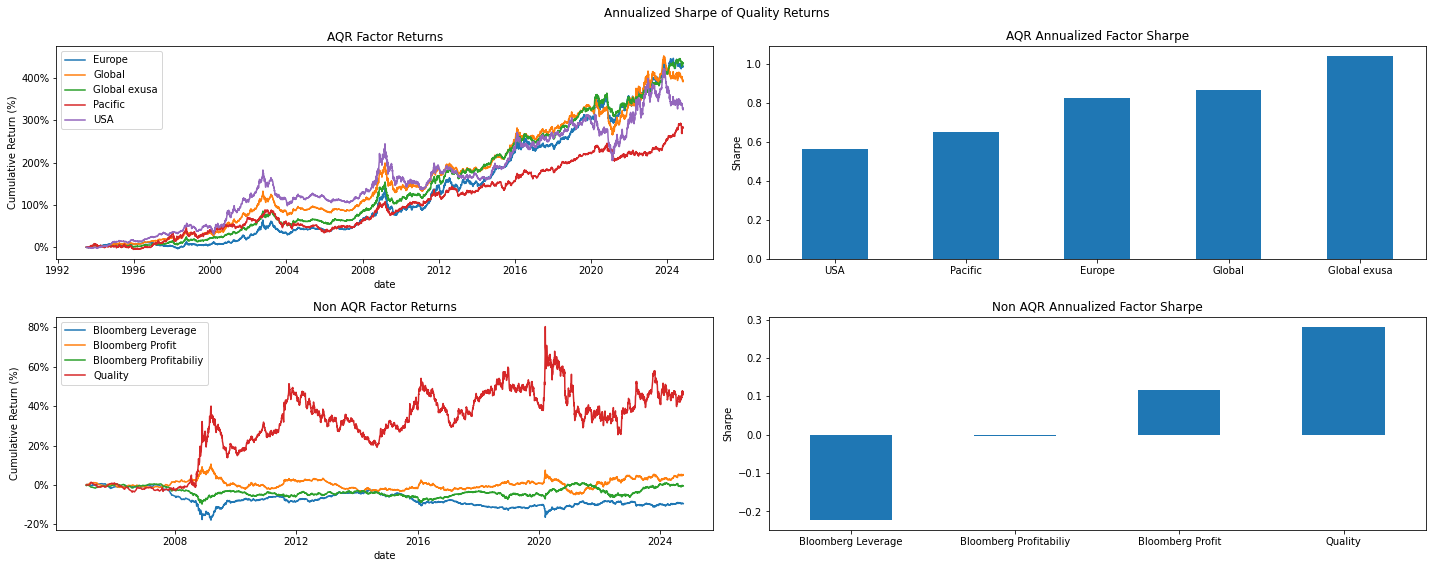

In [3]:
def plot_returns(df: pd.DataFrame) -> pd.DataFrame:

    groups    = df.group.drop_duplicates().sort_values().to_list()
    fig, axes = plt.subplots(ncols = len(groups), nrows = 2, figsize = (20,8))

    for i, group in enumerate(groups):

        df_wider = (df.query(
            "group == @group").
            rename(columns = {"variable": ""}).
            pivot(index = "date", columns = "", values = "value").
            dropna())

        df_sharpe = df_wider.mean() / df_wider.std() * np.sqrt(252)

        if group == "non_aqr": group = "Non AQR"

        (df_wider.apply(
            lambda x: np.cumprod(1 + x) -1).
            plot(
                ax     = axes[i,0],
                ylabel = "Cumulative Return (%)",
                title  = group + " Factor Returns"))

        (df_sharpe.sort_values().plot(
            kind   = "bar",
            ax     = axes[i,1],
            rot    = 0,
            ylabel = "Sharpe",
            title  = group + " Annualized Factor Sharpe"))

        axes[i,0].yaxis.set_major_formatter(FuncFormatter(lambda y, _: f'{y * 100:,.0f}%'))
        
    fig.suptitle("Annualized Sharpe of Quality Returns")
    plt.tight_layout()
    
plot_returns(df)

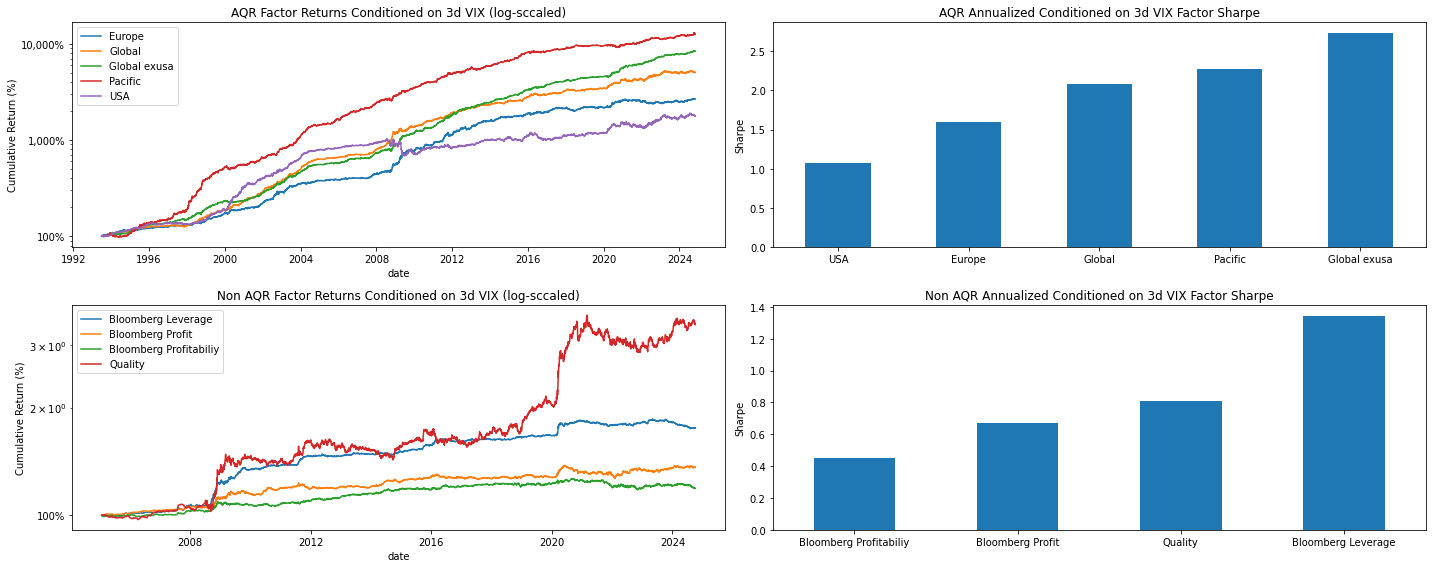

In [4]:
def plot_signal_rtn(df: pd.DataFrame) -> pd.DataFrame: 
    
    groups    = df.group.drop_duplicates().sort_values().to_list()
    fig, axes = plt.subplots(ncols = len(groups), nrows = 2, figsize = (20,8))

    for i, group in enumerate(groups):

        df_wider = (df.query(
            "group == @group").
            assign(signal_rtn = lambda x: np.sign(x.lag_resid) * x.value).
            rename(columns = {"variable": ""}).
            pivot(index = "date", columns = "", values = "signal_rtn").
            dropna())

        df_sharpe = df_wider.mean() / df_wider.std() * np.sqrt(252)

        if group == "non_aqr": group = "Non AQR"

        (df_wider.apply(
            lambda x: np.cumprod(1 + x)).
            plot(
                logy   = True,
                ax     = axes[i,0],
                ylabel = "Cumulative Return (%)",
                title  = group + " Factor Returns Conditioned on 3d VIX (log-sccaled)"))

        (df_sharpe.sort_values().plot(
            kind   = "bar",
            ax     = axes[i,1],
            rot    = 0,
            ylabel = "Sharpe",
            title  = group + " Annualized Conditioned on 3d VIX Factor Sharpe"))

        axes[i,0].yaxis.set_major_formatter(FuncFormatter(lambda y, _: f'{y * 100:,.0f}%'))
        
    plt.tight_layout()
    
plot_signal_rtn(df)

## Compare Results

In [5]:
def get_sharpe_comparison(df: pd.DataFrame) -> pd.DataFrame:
    
    df_out = (df.assign(
        signal_rtn = lambda x: np.sign(x.lag_resid) * x.value)
        [["variable", "date", "value", "signal_rtn"]].
        rename(columns = {
            "variable": "region",
            "value"   : "rtn"}).
        melt(id_vars = ["date", "region"]).
        drop(columns = ["date"]).
        groupby(["region", "variable"]).
        agg(["mean", "std"])
        ["value"].
        rename(columns = {
            "mean": "mean_rtn",
            "std" : "std_rtn"}).
        assign(sharpe = lambda x: x.mean_rtn / x.std_rtn * np.sqrt(252)).
        reset_index())
    
    return df_out

df_sharpe = get_sharpe_comparison(df)

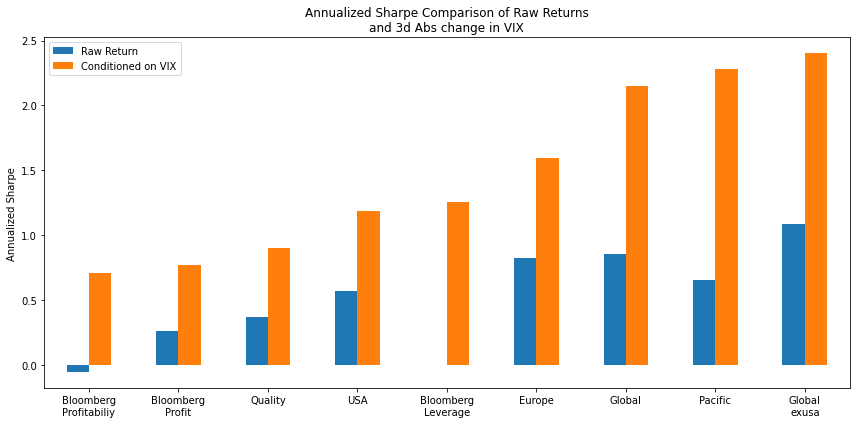

In [6]:
def plot_shapre(df_sharpe: pd.DataFrame) -> plt.Figure:
    
    (df_sharpe.assign(
        region = lambda x: x.region.str.replace(" ", "\n")).
        rename(columns = {"variable": ""}).
        pivot(index = "region", columns = "", values = "sharpe").
        sort_values("signal_rtn").
        rename(columns = {
            "rtn": "Raw Return",
            "signal_rtn": "Conditioned on VIX"}).
        plot(
            figsize = (12,6),
            kind    = "bar",
            rot     = 0,
            xlabel  = "",
            ylabel  = "Annualized Sharpe",
            title   = "Annualized Sharpe Comparison of Raw Returns\nand 3d Abs change in VIX"))
    
    plt.tight_layout()
    
plot_shapre(df_sharpe)

In [7]:
def _get_spread(df: pd.DataFrame) -> pd.DataFrame: 
    
    df_out = (df.set_index(
        "date").
        sort_index().
        assign(signal_rtn = lambda x: np.sign(x.lag_resid) * x.value)
        [["value", "signal_rtn"]])
    
    df_sharpe = df_out.rolling(window = 30).mean() / df_out.rolling(window = 30).std() * np.sqrt(252)
    df_spread = (df_sharpe.assign(
        spread = lambda x: x.signal_rtn - x.value).
        dropna())
    
    t_test, p_value = (ttest_1samp(
        a       = df_spread.spread,
        popmean = 0))
    
    t_dict = {
        "mean_val": df_spread.spread.mean(),
        "t_stat"  : t_test,
        "p_value" : p_value}
    
    df_out = (pd.DataFrame.from_dict(
        data    = t_dict, 
        orient  = "index",
        columns = ["value"]))
    
    return df_out

def get_sharpe_comparison(df: pd.DataFrame) -> pd.DataFrame: 

    df_out = (df.groupby(
        "variable").
        apply(_get_spread).
        reset_index().
        rename(columns = {"level_1": "param"}))
    
    return df_out

df_sharpe_compare = get_sharpe_comparison(df)

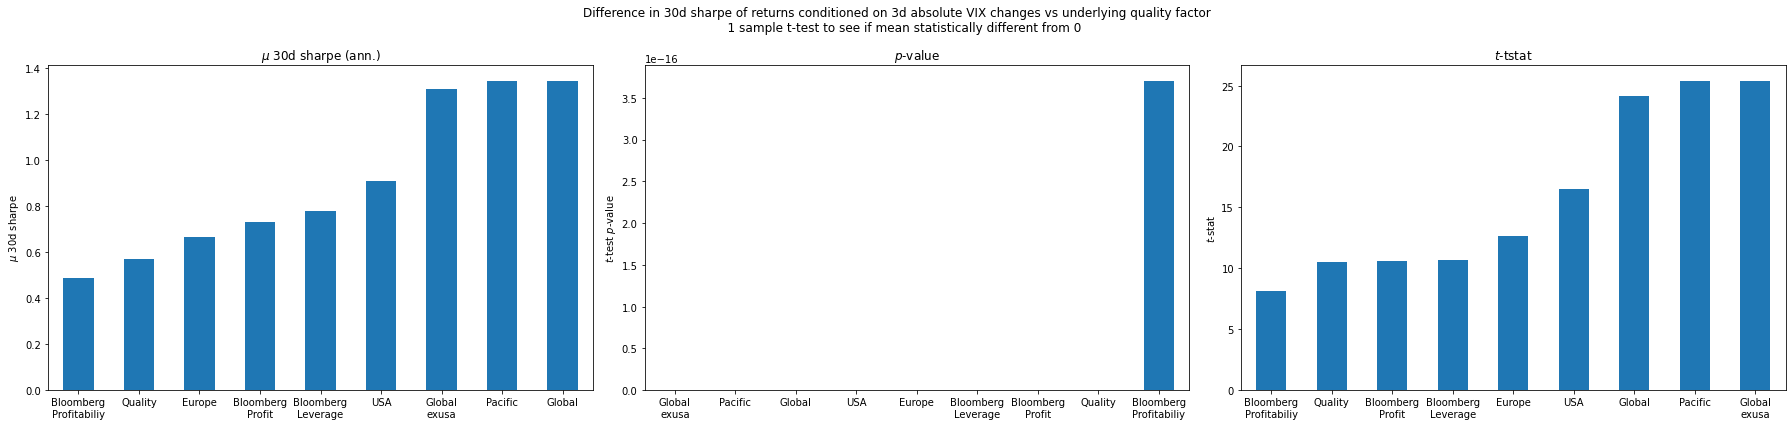

In [8]:
def plot_tstat(df_sharpe_compare: pd.DataFrame) -> plt.Figure: 
    
    params    = df_sharpe_compare.param.drop_duplicates().sort_values().to_list()
    fig, axes = plt.subplots(ncols = len(params), figsize = (25,6))

    title_renamer = {
        "mean_val": r"$\mu$ 30d sharpe (ann.)",
        "p_value" : r"$p$-value",
        "t_stat"  : r"$t$-tstat"}

    ylabel_renamer = {
        "mean_val": r"$\mu$ 30d sharpe",
        "p_value" : r"$t$-test $p$-value",
        "t_stat"  : r"$t$-stat"}

    for param, ax in zip(params, axes.flatten()):

        (df_sharpe_compare.query(
            "param == @param").
            assign(variable = lambda x: x.variable.str.replace(" ", "\n")).
            set_index("variable").
            sort_values("value").
            plot(
                ax     = ax,
                kind   = "bar",
                xlabel = "",
                ylabel = ylabel_renamer[param],
                title  = title_renamer[param],
                legend = False,
                rot    = 0))

    fig.suptitle('''Difference in 30d sharpe of returns conditioned on 3d absolute VIX changes vs underlying quality factor
    1 sample t-test to see if mean statistically different from 0''')
    plt.tight_layout()
    
plot_tstat(df_sharpe_compare)

## The regression

In [9]:
def _get_ols_params(df: pd.DataFrame) -> pd.DataFrame:
    
    df_tmp = (df.set_index(
        "date").
        sort_index())

    model = (sm.OLS(
        endog = df_tmp.value,
        exog  = sm.add_constant(df_tmp.VIX_shock)).
        fit())
    
    df_val = (model.params.to_frame(
        name = "val").
        reset_index())
    
    df_out = (model.pvalues.to_frame(
        name = "pval").
        reset_index().
        merge(right = df_val, how = "inner", on = ["index"]))
    
    return df_out
    
def get_params(df) -> pd.DataFrame: 

    df_out = (df.groupby(
        "variable").
        apply(_get_ols_params).
        reset_index().
        drop(columns = ["level_1"]))
    
    return df_out

df_params = get_params(df)

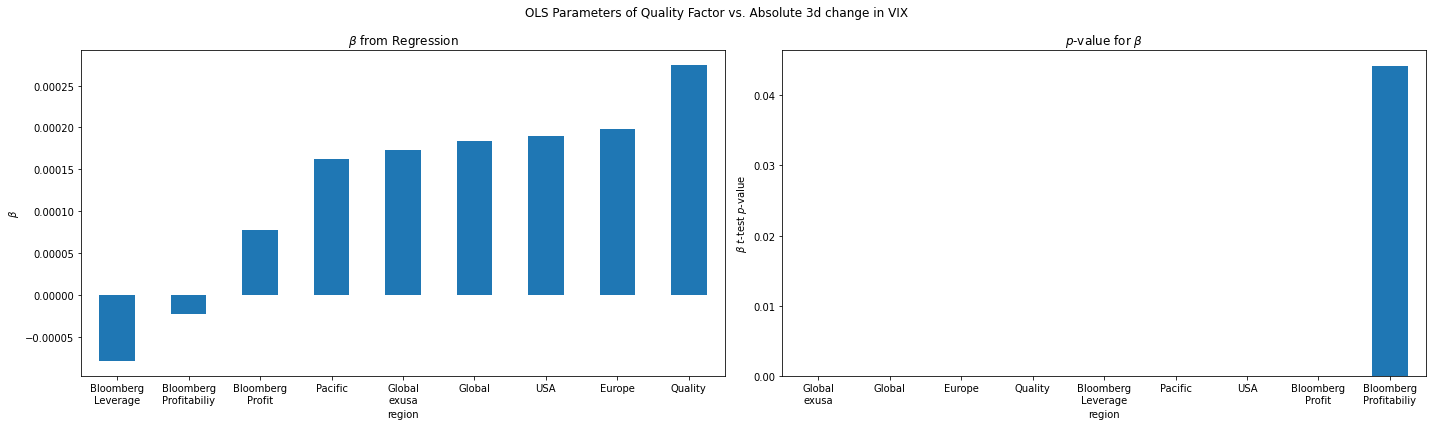

In [10]:
def plot_params(df_params: pd.DataFrame) -> plt.Figure:
    
    df_longer = (df_params.rename(
        columns = {"variable": "region"}).
        melt(id_vars = ["region", "index"]).
        query("index == 'VIX_shock'"))

    variables = df_longer.variable.drop_duplicates().sort_values(ascending = False).to_list()
    fig, axes = plt.subplots(ncols = len(variables), figsize = (20,6))

    for variable, ax in zip(variables, axes.flatten()):

        df_plot = (df_longer.query(
            "variable == @variable").
            assign(region = lambda x: x.region.str.replace(" ", "\n")).
            set_index("region")
            [["value"]].
            sort_values("value"))

        (df_plot.plot(
            ax     = ax,
            kind   = "bar",
            legend = False,
            rot    = 0))

        if variable == "pval": 
            ax.set_ylabel(r"$\beta$ $t$-test $p$-value")
            ax.set_title(r"$p$-value for $\beta$")

        else: 
            ax.set_ylabel(r"$\beta$")
            ax.set_title(r"$\beta$ from Regression")

    fig.suptitle("OLS Parameters of Quality Factor vs. Absolute 3d change in VIX")
    plt.tight_layout()
    
plot_params(df_params)

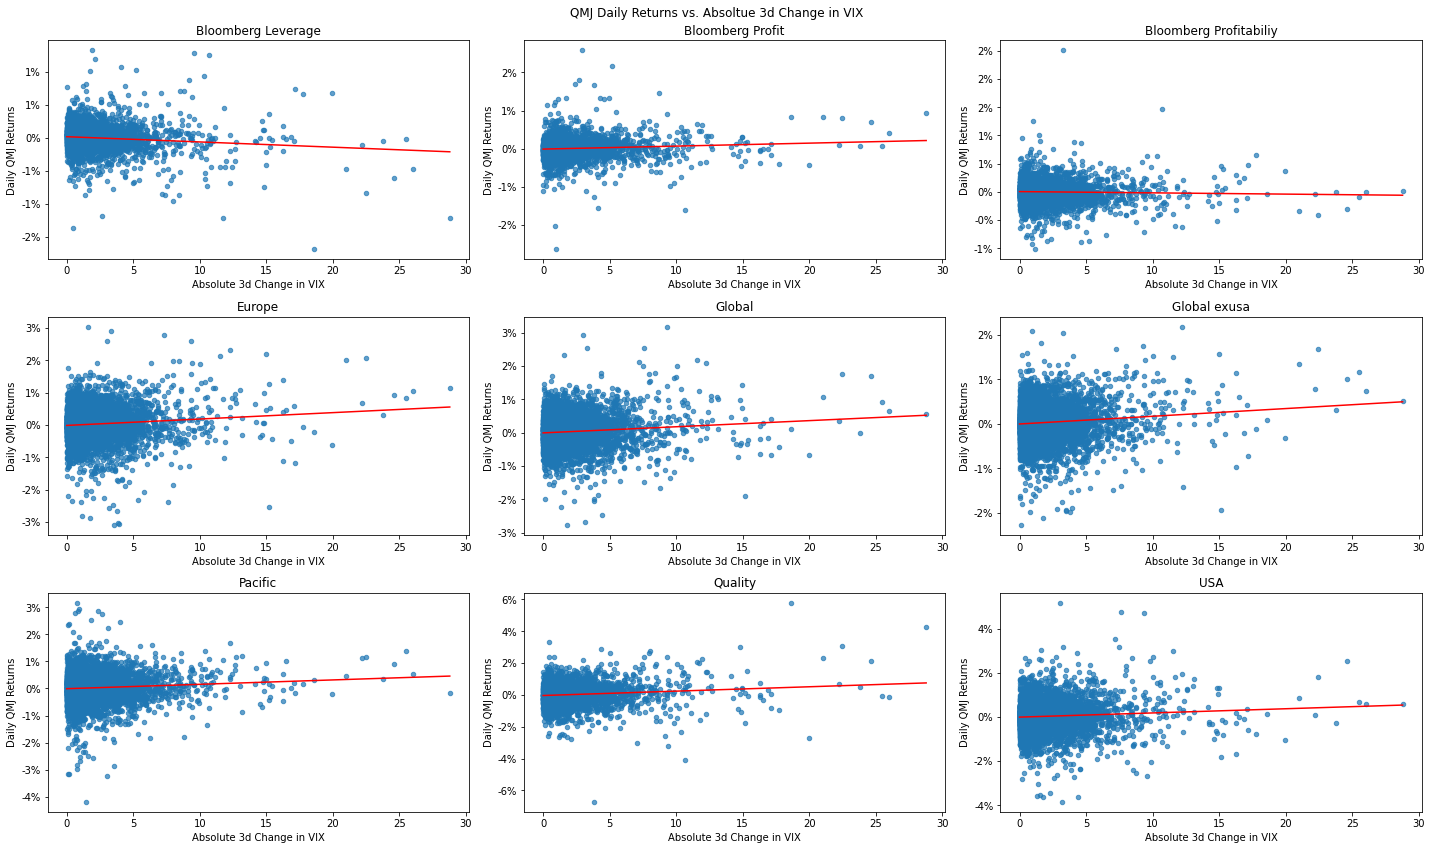

In [11]:
def plot_regression(df_params: pd.DataFrame, df: pd.DataFrame) -> plt.Figure:
 
    variables = df_params.variable.drop_duplicates().sort_values().to_list()
    fig, axes = plt.subplots(ncols = 3, nrows = 3, figsize = (20,12))

    for variable, ax in zip(variables, axes.flatten()):

        raw_params = (df_params.query(
            "variable == @variable").
            set_index("index").
            val.
            to_dict())

        df_tmp = df.query("variable == @variable")
        x      = np.linspace(
            start = df_tmp.VIX_shock.min(), 
            stop  = df_tmp.VIX_shock.max(), 
            num   = 1_000)

        y      = (x * raw_params["VIX_shock"]) + raw_params["const"]

        (df_tmp.plot(
            ax    = ax,
            kind  = "scatter",
            x     = "VIX_shock",
            y     = "value",
            alpha = 0.7,
            title = variable))

        ax.plot(x, y, color = "red")
        ax.set_xlabel("Absolute 3d Change in VIX")
        ax.set_ylabel("Daily QMJ Returns")
        ax.yaxis.set_major_formatter(FuncFormatter(lambda y, _: f'{y * 100:.0f}%'))

    fig.suptitle("QMJ Daily Returns vs. Absoltue 3d Change in VIX")
    plt.tight_layout()
    
plot_regression(df_params, df)